In [ ]:
# Full pipeline: original preprocessing + proper split + SMOTE in pipeline + tuning + metrics + PCA
# Note: run in a Python environment with packages: pandas, numpy, matplotlib, seaborn, scikit-learn,
# catboost, imbalanced-learn. If missing, install them via pip.

# ---------------------------------------
# Imports
# ---------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Install (if needed in notebook) - uncomment in a notebook environment:
!pip install catboost imbalanced-learn --quiet

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 1) Load dataset
# ---------------------------------------
df = pd.read_csv("heart_disease.csv")
print("Initial Shape:", df.shape)
display(df.head())

Initial Shape: (10000, 21)


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


In [ ]:
# 2) Basic missing-value handling (global)
#    — fill numeric with median, categorical with mode
# ---------------------------------------
numeric_cols_all = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols_all = df.select_dtypes(include=['object']).columns.tolist()

for col in numeric_cols_all:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols_all:
    df[col] = df[col].fillna(df[col].mode().iloc[0])

print("After basic imputation shape:", df.shape)

After basic imputation shape: (10000, 21)


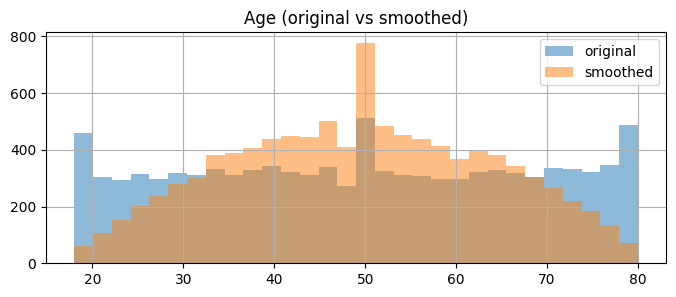

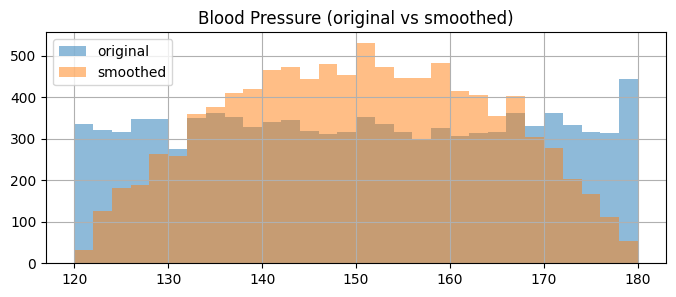

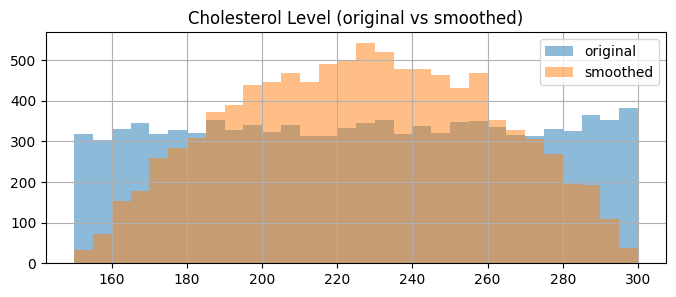

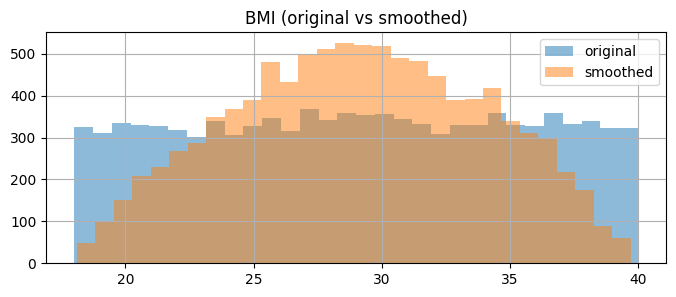

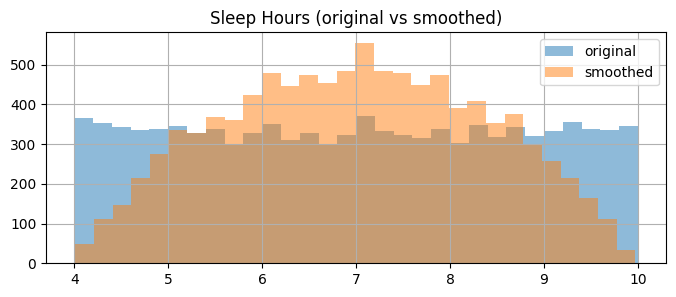

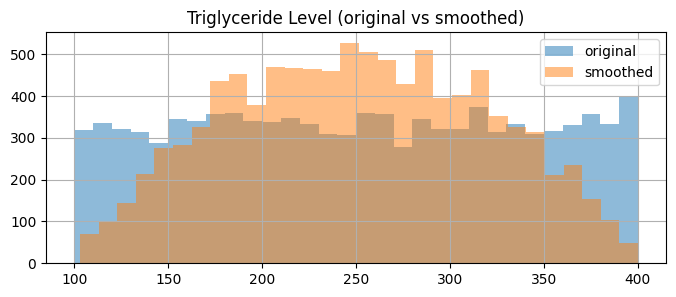

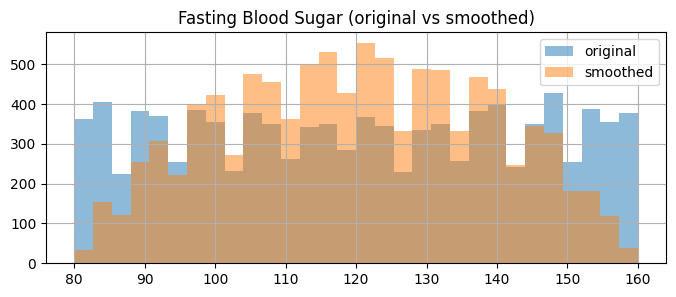

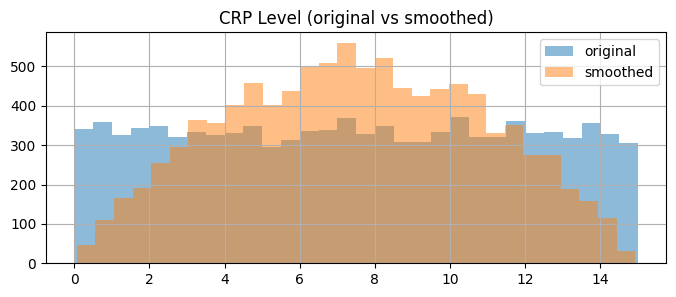

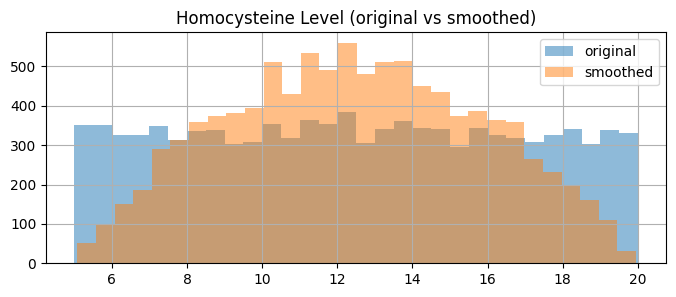

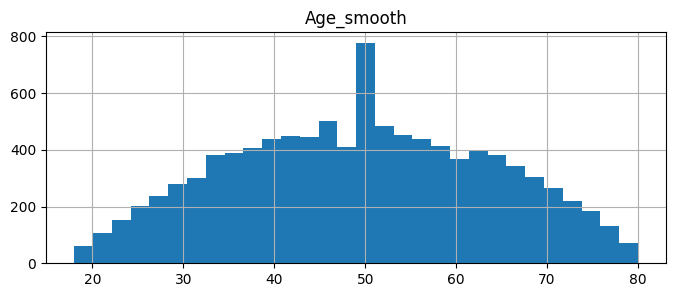

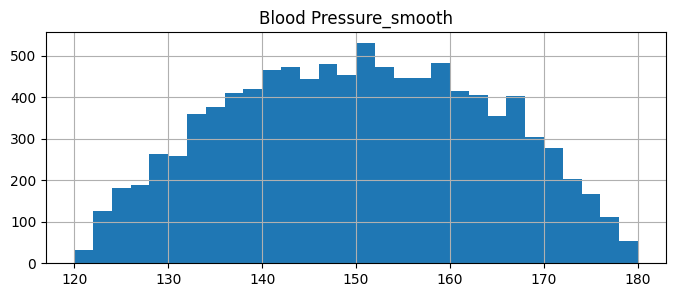

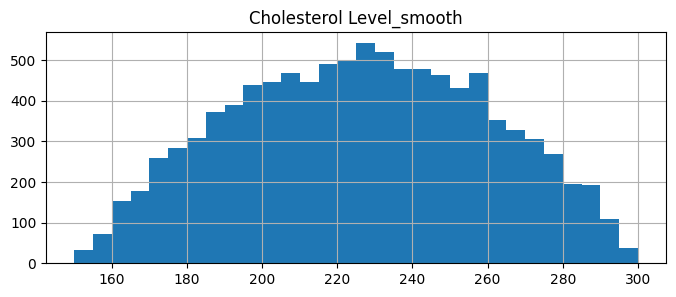

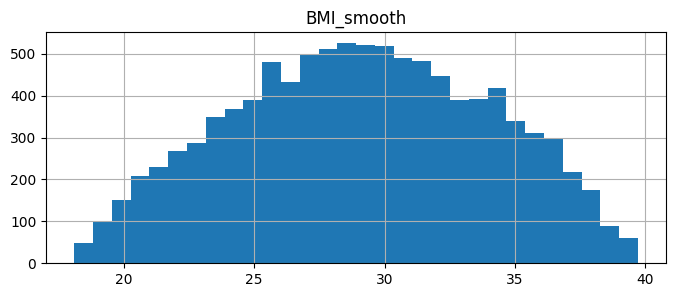

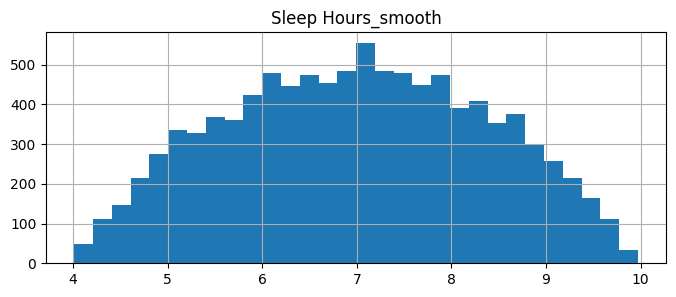

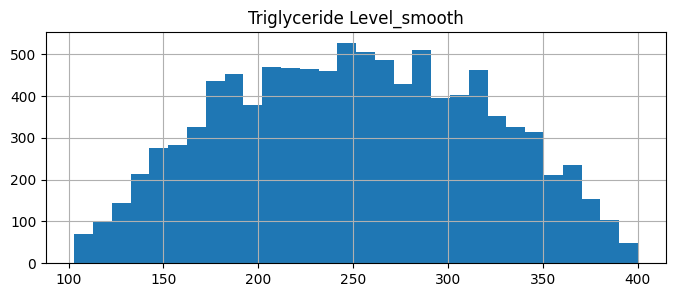

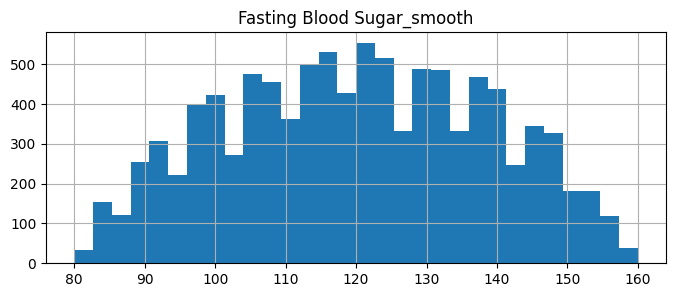

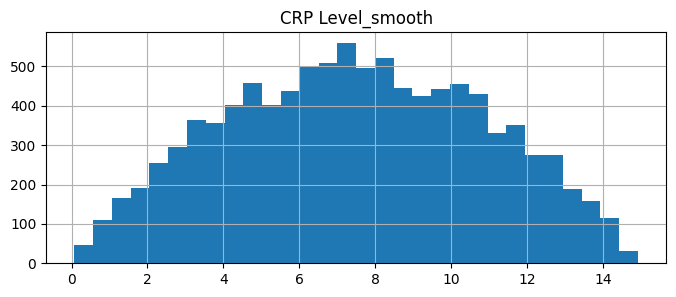

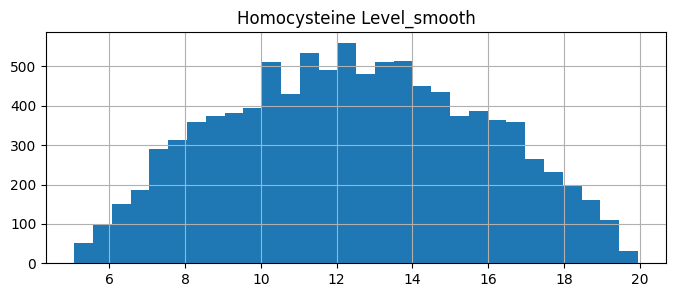

In [ ]:
# 3) Smoothing: add "_smooth" versions for numeric columns (as in your original)
# ---------------------------------------
for col in df.select_dtypes(include=["number"]).columns:
    if col != "Heart Disease Status":  # keep target untouched
        df[col + "_smooth"] = df[col].rolling(window=3, center=True, min_periods=1).median()

# Optional: plot a few histograms (original vs smoothed)
num_cols = [c for c in df.select_dtypes(include=["number"]).columns if c != "Heart Disease Status"]
for col in num_cols:
    plt.figure(figsize=(8,3))
    if col + "_smooth" in df.columns:
        df[col].hist(bins=30, alpha=0.5, label="original")
        df[col + "_smooth"].hist(bins=30, alpha=0.5, label="smoothed")
        plt.title(f"{col} (original vs smoothed)")
        plt.legend()
        plt.show()
    else:
        df[col].hist(bins=30)
        plt.title(col)
        plt.show()


Target distribution:


,count
Heart Disease Status,
No,8000
Yes,2000


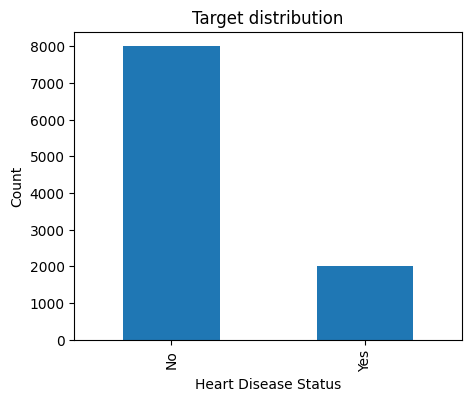

In [ ]:
# 4) Target overview
# ---------------------------------------
print("\nTarget distribution:")
display(df["Heart Disease Status"].value_counts())
plt.figure(figsize=(5,4))
df["Heart Disease Status"].value_counts().plot(kind="bar", title="Target distribution")
plt.xlabel("Heart Disease Status"); plt.ylabel("Count")
plt.show()

Duplicate rows before: 0
Dataset shape after dropping duplicates: (10000, 30)


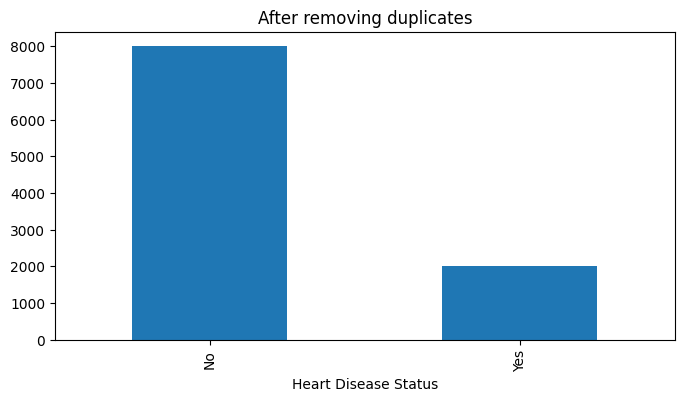

In [ ]:
# 5) Remove duplicates (as in original)
# ---------------------------------------
print(f"Duplicate rows before: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dataset shape after dropping duplicates: {df.shape}")

plt.figure(figsize=(8,4))
df["Heart Disease Status"].value_counts().plot(kind="bar", title="After removing duplicates")
plt.show()


Shape before outlier removal: (10000, 30)
Shape after outlier removal: (10000, 30)


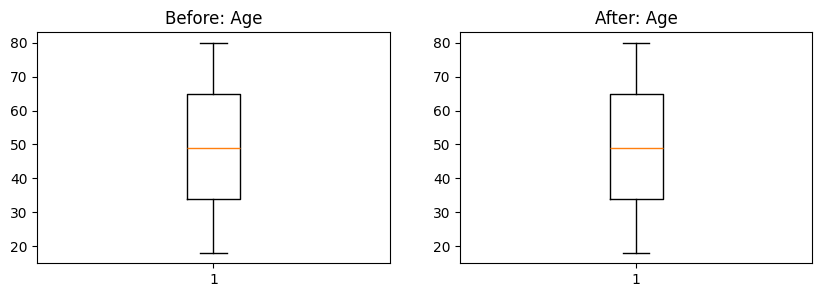

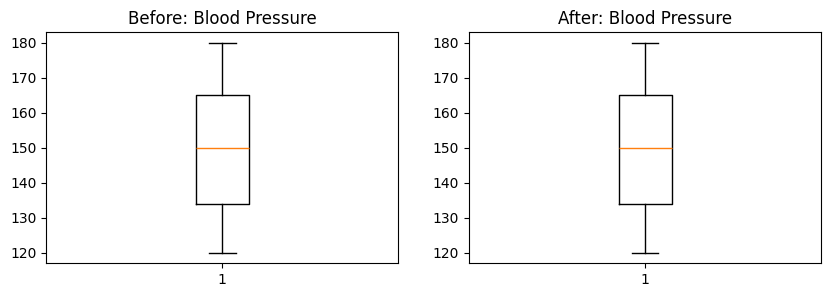

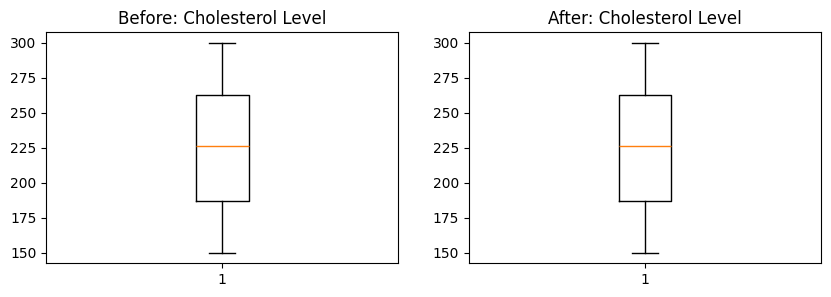

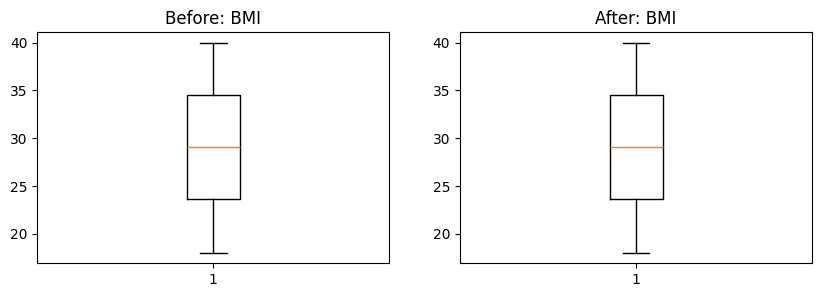

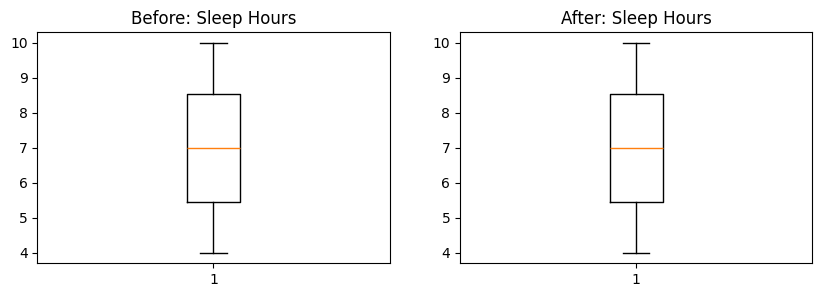

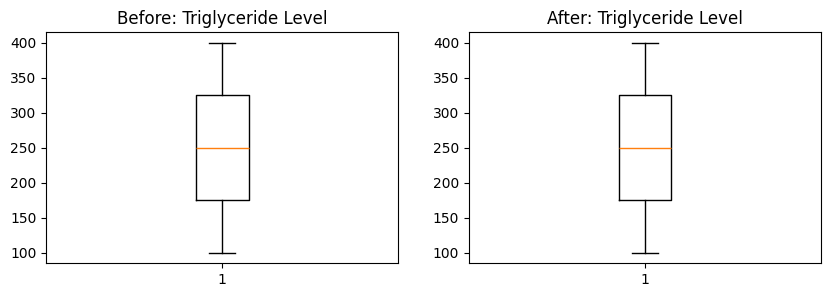

In [ ]:
# 6) Outlier detection + optional removal (IQR approach)
#    Keep a cleaned copy for comparison; we will proceed using the cleaned dataframe to avoid extreme outliers.
# ---------------------------------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if "Heart Disease Status" in numeric_cols:
    numeric_cols.remove("Heart Disease Status")

def remove_outliers_iqr(data, columns):
    cleaned = data.copy()
    for col in columns:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

df_cleaned = remove_outliers_iqr(df, numeric_cols)
print("Shape before outlier removal:", df.shape)
print("Shape after outlier removal:", df_cleaned.shape)

# Plot boxplots before vs after for a few columns
for col in numeric_cols[:6]:  # limit to first 6 for speed
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].boxplot(df[col].dropna()); ax[0].set_title(f"Before: {col}")
    ax[1].boxplot(df_cleaned[col].dropna()); ax[1].set_title(f"After: {col}")
    plt.show()

# For downstream modeling we'll use df_cleaned (safer); if it becomes too small you can revert to df.
df = df_cleaned.copy()


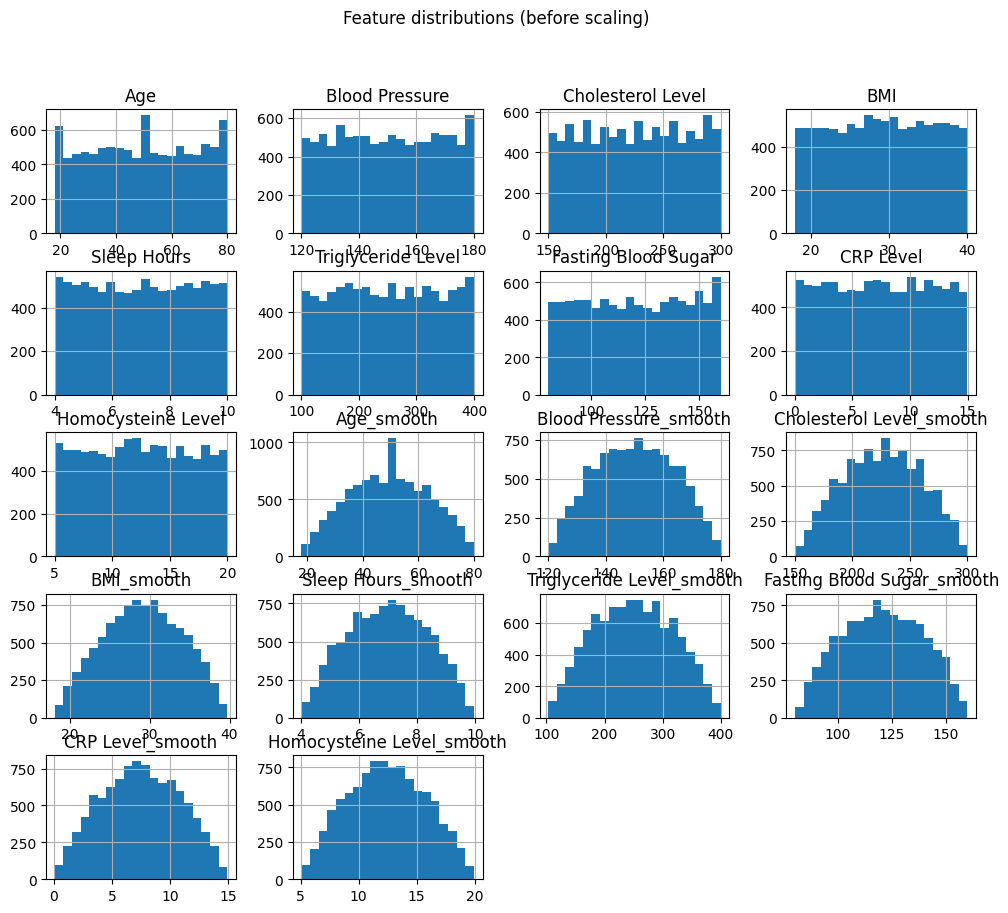

In [ ]:
# 7) Scaling check — choose StandardScaler or MinMax based on outliers presence
#    We will apply scaling inside the Pipeline (so do not globally scale here).
# ---------------------------------------
# (we will still show histograms before scaling for presentation)
df.hist(figsize=(12,10), bins=20)
plt.suptitle("Feature distributions (before scaling)")
plt.show()

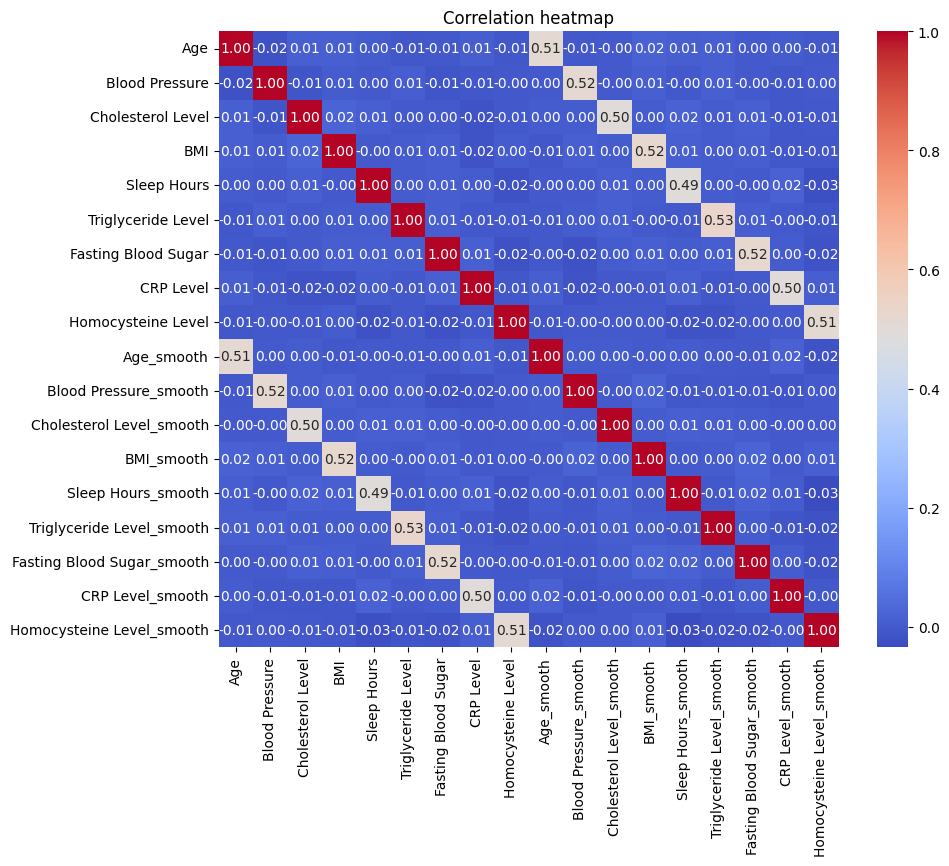

In [ ]:
# 8) Correlation heatmap (for numeric features)
# ---------------------------------------
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()


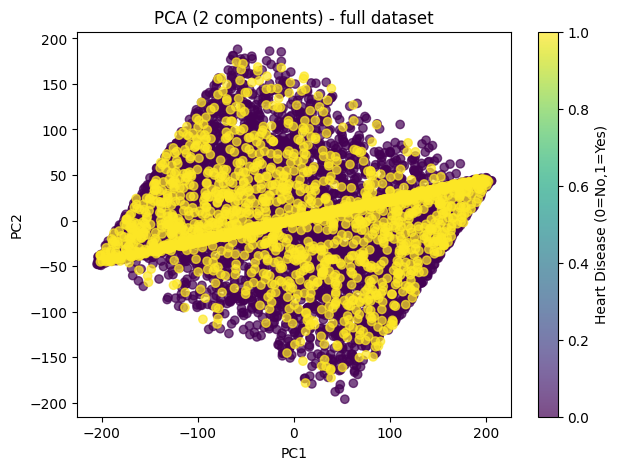

In [ ]:
# 9) PCA visualization (for 2 components) — this is before splitting just to visualize overall structure.
#    We'll encode target to numeric for coloring.
# ---------------------------------------
X_for_pca = df.drop("Heart Disease Status", axis=1)
# We must one-hot encode categorical features for PCA -> quick simple get_dummies for visualization only
X_pca = pd.get_dummies(X_for_pca, drop_first=True)
# Align row counts (drop rows with missing after one-hot, but we imputed earlier)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_pca.fillna(0))  # fillna 0 for safety

y_numeric = np.where(df["Heart Disease Status"] == "Yes", 1, 0)

plt.figure(figsize=(7,5))
plt.scatter(pca_result[:,0], pca_result[:,1], c=y_numeric, cmap="viridis", alpha=0.7)
plt.title("PCA (2 components) - full dataset")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="Heart Disease (0=No,1=Yes)")
plt.show()


In [ ]:
# 10) Prepare X and y (final) and perform the correct train-test split (IMPORTANT: split BEFORE training operations)
# ---------------------------------------
X = df.drop("Heart Disease Status", axis=1)
y = df["Heart Disease Status"].copy()  # keep as "Yes"/"No" strings for readability

# Confirm target values
print("Unique target labels:", y.unique())

# Correct split (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Unique target labels: ['No' 'Yes']
Train shape: (8000, 29) Test shape: (2000, 29)


In [ ]:
# 11) Preprocessing pipelines (numeric + categorical)
#     We'll automatically detect numeric and categorical columns from training set to avoid leakage.
# ---------------------------------------
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")

Numeric features: ['Age', 'Blood Pressure', 'Cholesterol Level', 'BMI', 'Sleep Hours', 'Triglyceride Level', 'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level', 'Age_smooth', 'Blood Pressure_smooth', 'Cholesterol Level_smooth', 'BMI_smooth', 'Sleep Hours_smooth', 'Triglyceride Level_smooth', 'Fasting Blood Sugar_smooth', 'CRP Level_smooth', 'Homocysteine Level_smooth']
Categorical features: ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sugar Consumption']


In [ ]:
# 12) Build imblearn Pipeline:
#     preprocessor -> SelectKBest -> SMOTE -> CatBoost
#     Using imblearn's Pipeline ensures SMOTE is only applied to training folds during CV/tuning.
# ---------------------------------------
# choose k for SelectKBest (you used k=8 earlier; keep that but it can be tuned as well)
k_features = 8
cat_estimator = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='Accuracy',
    random_state=42,
    verbose=0
)

imb_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_classif, k=k_features)),
    ("smote", SMOTE(random_state=42)),
    ("classifier", cat_estimator)
])


--- Baseline training (before hyperparameter tuning) ---
Baseline Accuracy : 79.20%
Baseline F1 Score : 0.0370
Baseline Precision: 0.2500
Baseline Recall   : 0.0200
Baseline AUC      : 0.5306

Classification Report (baseline):
              precision    recall  f1-score   support

          No       0.80      0.98      0.88      1600
         Yes       0.25      0.02      0.04       400

    accuracy                           0.79      2000
   macro avg       0.53      0.50      0.46      2000
weighted avg       0.69      0.79      0.71      2000



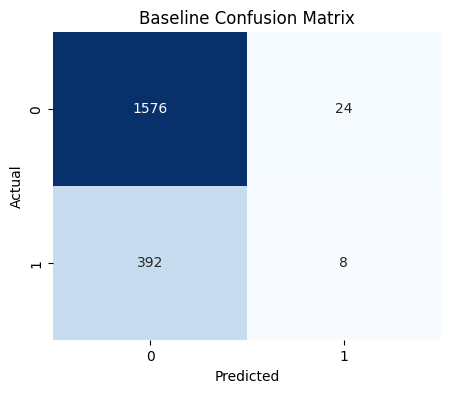

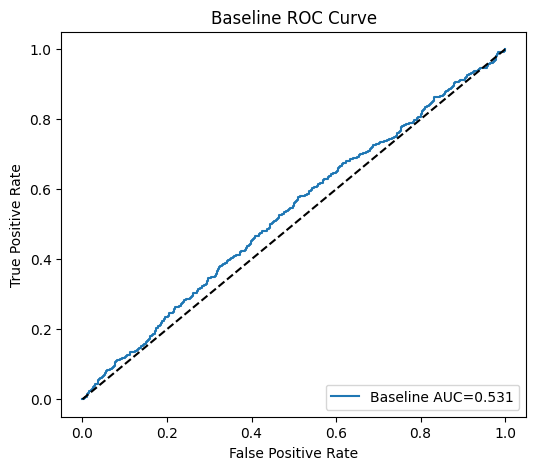

In [ ]:
# 13) Baseline training (fit pipeline on training set and evaluate on test set) — BEFORE hyperparameter tuning
# ---------------------------------------
print("\n--- Baseline training (before hyperparameter tuning) ---")
imb_pipeline.fit(X_train, y_train)
y_pred_base = imb_pipeline.predict(X_test)

# For AUC we need probability of positive class; ensure classifier has predict_proba
if hasattr(imb_pipeline.named_steps["classifier"], "predict_proba"):
    y_proba_base = imb_pipeline.predict_proba(X_test)[:, 1]
else:
    # fallback: decision_function or zeros
    try:
        y_proba_base = imb_pipeline.decision_function(X_test)
    except:
        y_proba_base = np.zeros(len(y_test))

# Convert y_test to binary 0/1 for AUC calculation (Yes=1)
y_test_bin = (y_test == "Yes").astype(int)

acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, pos_label="Yes")
prec_base = precision_score(y_test, y_pred_base, pos_label="Yes")
recall_base = recall_score(y_test, y_pred_base, pos_label="Yes")
auc_base = roc_auc_score(y_test_bin, y_proba_base)

print(f"Baseline Accuracy : {acc_base*100:.2f}%")
print(f"Baseline F1 Score : {f1_base:.4f}")
print(f"Baseline Precision: {prec_base:.4f}")
print(f"Baseline Recall   : {recall_base:.4f}")
print(f"Baseline AUC      : {auc_base:.4f}")
print("\nClassification Report (baseline):")
print(classification_report(y_test, y_pred_base))

# Confusion matrix (baseline)
cm_base = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve (baseline)
fpr_base, tpr_base, _ = roc_curve(y_test_bin, y_proba_base)
plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, label=f"Baseline AUC={auc_base:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("Baseline ROC Curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 14) Hyperparameter tuning with RandomizedSearchCV
#     Use StratifiedKFold to preserve class proportions in CV
# ---------------------------------------
param_distributions = {
    "classifier__depth": [4, 6, 8, 10],
    "classifier__learning_rate": [0.005, 0.01, 0.03, 0.05, 0.1],
    "classifier__iterations": [300, 500, 800, 1000],
    "classifier__l2_leaf_reg": [1, 3, 5, 7, 9],
    "classifier__bagging_temperature": [0, 0.5, 1, 2],
    "feature_selection__k": [6, 8, 10, 12]  # allow tuning of selected K as well
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=imb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,            # increase to explore more (adjust depending on compute)
    scoring="accuracy",
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\n--- Running RandomizedSearchCV for hyperparameter tuning ---")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)


--- Running RandomizedSearchCV for hyperparameter tuning ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters found:
{'feature_selection__k': 12, 'classifier__learning_rate': 0.03, 'classifier__l2_leaf_reg': 9, 'classifier__iterations': 1000, 'classifier__depth': 6, 'classifier__bagging_temperature': 0.5}
Best CV accuracy: 0.788125



--- Tuned Model Evaluation on Test Set ---
Tuned Accuracy : 79.50%
Tuned F1 Score : 0.0330
Tuned Precision: 0.2917
Tuned Recall   : 0.0175
Tuned AUC      : 0.5439

Classification Report (tuned):
              precision    recall  f1-score   support

          No       0.80      0.99      0.89      1600
         Yes       0.29      0.02      0.03       400

    accuracy                           0.80      2000
   macro avg       0.55      0.50      0.46      2000
weighted avg       0.70      0.80      0.71      2000



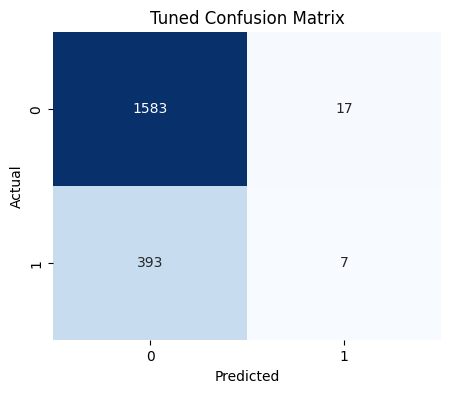

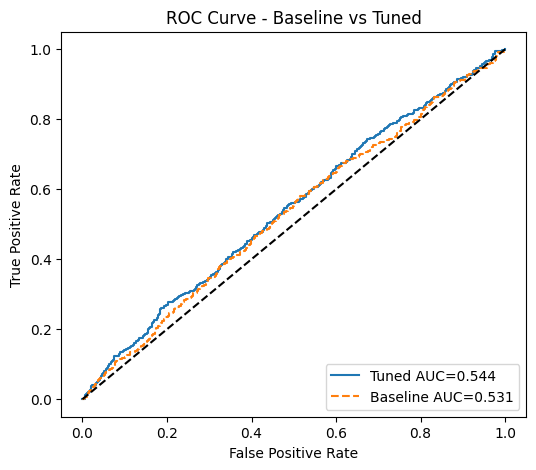

In [ ]:
# 15) Evaluate the best estimator on test set (AFTER tuning)
# ---------------------------------------
best_pipeline = random_search.best_estimator_
y_pred_tuned = best_pipeline.predict(X_test)
y_proba_tuned = best_pipeline.predict_proba(X_test)[:, 1]

acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned, pos_label="Yes")
prec_tuned = precision_score(y_test, y_pred_tuned, pos_label="Yes")
recall_tuned = recall_score(y_test, y_pred_tuned, pos_label="Yes")
auc_tuned = roc_auc_score(y_test_bin, y_proba_tuned)

print("\n--- Tuned Model Evaluation on Test Set ---")
print(f"Tuned Accuracy : {acc_tuned*100:.2f}%")
print(f"Tuned F1 Score : {f1_tuned:.4f}")
print(f"Tuned Precision: {prec_tuned:.4f}")
print(f"Tuned Recall   : {recall_tuned:.4f}")
print(f"Tuned AUC      : {auc_tuned:.4f}")
print("\nClassification Report (tuned):")
print(classification_report(y_test, y_pred_tuned))

# Confusion matrix (tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve (tuned)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_bin, y_proba_tuned)
plt.figure(figsize=(6,5))
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned AUC={auc_tuned:.3f}")
plt.plot(fpr_base, tpr_base, label=f"Baseline AUC={auc_base:.3f}", linestyle='--')
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Baseline vs Tuned")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 16) Feature names and selected features (for explainability)
#     Extract feature names after preprocessor and onehot encoding
# ---------------------------------------
# Fit preprocessor on whole training data to extract feature names (if not already)
pre = best_pipeline.named_steps['preprocessor']
# For OneHotEncoder get_feature_names_out requires fitted encoder; ensure preprocessor fitted on training
# pre was fitted inside pipeline; but to be safe we will use it directly.

# numeric names
num_names = numeric_features

# categorical OHE names
cat_ohe = pre.named_transformers_['cat'].named_steps['onehot']
cat_names = list(cat_ohe.get_feature_names_out(categorical_features)) if hasattr(cat_ohe, 'get_feature_names_out') else []

all_feature_names = list(num_names) + cat_names

# Now get mask from feature_selection (it is SelectKBest)
sel = best_pipeline.named_steps['feature_selection']
mask = sel.get_support()
selected_feature_names = [name for name, m in zip(all_feature_names, mask) if m]

print("\nSelected feature names (after preprocessing & selection):")
print(selected_feature_names)

# If we want, we can compute feature importances from CatBoost
cb = best_pipeline.named_steps['classifier']
try:
    importances = cb.get_feature_importance(prettified=True)
    print("\nCatBoost: feature importance (raw):")
    # Note: get_feature_importance will give importance based on internal ordering; mapping to selected features would require careful alignment
    display(importances[:20])
except Exception as e:
    print("Could not extract CatBoost importances directly:", e)


Selected feature names (after preprocessing & selection):
['Age', 'BMI', 'Age_smooth', 'Blood Pressure_smooth', 'BMI_smooth', 'Homocysteine Level_smooth', 'Gender_Female', 'Gender_Male', 'Alcohol Consumption_Medium', 'Stress Level_Low', 'Stress Level_Medium', 'Sugar Consumption_High']

CatBoost: feature importance (raw):


,Feature Id,Importances
0,3,17.924371
1,8,16.135860
2,2,15.240405
3,11,15.209662
4,9,10.750333
5,10,9.685249
6,0,6.470920
7,5,2.639088
8,4,2.536080
9,1,2.043666


In [ ]:
# 17) Detailed comparison summary table
# ---------------------------------------
summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "Precision", "Recall", "AUC"],
    "Baseline": [acc_base, f1_base, prec_base, recall_base, auc_base],
    "Tuned": [acc_tuned, f1_tuned, prec_tuned, recall_tuned, auc_tuned]
})

print("\n=== Detailed Metrics Comparison ===")
display(summary_df.style.format({"Baseline": "{:.4f}", "Tuned": "{:.4f}"}))


=== Detailed Metrics Comparison ===


,Metric,Baseline,Tuned
0,Accuracy,0.7920,0.7950
1,F1 Score,0.0370,0.0330
2,Precision,0.2500,0.2917
3,Recall,0.0200,0.0175
4,AUC,0.5306,0.5439
